# Riparian Forest Data Analysis

This notebook analyzes riparian vegetation data from river sections in the Arve and Valserine basins.

**Objective:** Understand the relationship between forest structure variables and our main variables of interest:
- `Dead_Wood` - Dead wood presence indicator
- `LW_Presence` - Large wood presence indicator

## 1. Data Loading & Preparation

In [69]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skrub import TableReport

# Scikit-learn imports for later analysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Load the Excel file
df = pd.read_excel(r'C:\Users\jdelhoyo\PhD\Study cases\Genissiat\RV Characterization\Excel (from access)\RV_For_RF2.xlsx')

# Remove Rhone basin to avoid contamination
df = df[df['Basin'] != 'Rhone'].copy()

print(f"Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Basins: {df['Basin'].unique()}")

Dataset shape: 78 rows × 30 columns
Basins: ['Arve' 'Valserine']


In [70]:
# Define column groups for analysis
ID_COLS = ['Id_Data', 'Id_Place', 'Basin', 'Sub_Basin', 'Stand_Code', 'Bank', 'Cod_Plg']
TARGET_COLS = ['Dead_Wood', 'LW_Presence']
DATA_COLS = [col for col in df.columns if col not in ID_COLS]
FEATURE_COLS = [col for col in DATA_COLS if col not in TARGET_COLS]

print(f"ID columns ({len(ID_COLS)}): {ID_COLS}")
print(f"\nTarget variables: {TARGET_COLS}")
print(f"\nFeature columns ({len(FEATURE_COLS)}): {FEATURE_COLS}")

ID columns (7): ['Id_Data', 'Id_Place', 'Basin', 'Sub_Basin', 'Stand_Code', 'Bank', 'Cod_Plg']

Target variables: ['Dead_Wood', 'LW_Presence']

Feature columns (21): ['Standing_Dead_Trees', 'Regeneration', 'Basal_Area (m2/ha)', 'Sinuosity', 'Width_Mean', 'Lat_Connectivity', 'Gradient (%)', 'SPI / Width', 'SPI', 'Lentgh (m)', 'P50_Height', 'Height_IQR', 'HardWood_Ab', 'SoftWood_Ab', 'Pioneers_Ab', 'Shrubs_Ab', 'Brambles_Ab', 'Invasive_Ab', 'MaxDiamClass', 'DiamComplex', 'StructuralIndex']


## 2. Data Overview & Profiling

Using skrub's `TableReport` for an interactive overview of the dataset.

In [71]:
# Interactive data profile with skrub
TableReport(df)

Processing column  30 / 30


,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [72]:
# Data structure: samples per Basin and Sub_Basin
structure_summary = df.groupby(['Basin', 'Sub_Basin']).size().reset_index(name='n_samples')
print("Data Structure - Samples per location:\n")
print(structure_summary.to_string(index=False))

# Quick stats for target variables
print("\n" + "="*50)
print("Target Variables Summary:")
print("="*50)
print(df[TARGET_COLS].describe())

Data Structure - Samples per location:

    Basin Sub_Basin  n_samples
     Arve      Arve         34
     Arve    Giffre         16
     Arve    Menoge          6
Valserine    Semine          8
Valserine Valserine         14

Target Variables Summary:
       Dead_Wood  LW_Presence
count  78.000000    78.000000
mean    2.628205     2.615385
std     0.913236     1.034857
min     1.000000     1.000000
25%     2.000000     2.000000
50%     3.000000     3.000000
75%     3.000000     3.750000
max     4.000000     4.000000


## 3. Target Variable Distributions

Examining the distribution of our main variables of interest: `Dead_Wood` and `LW_Presence`.

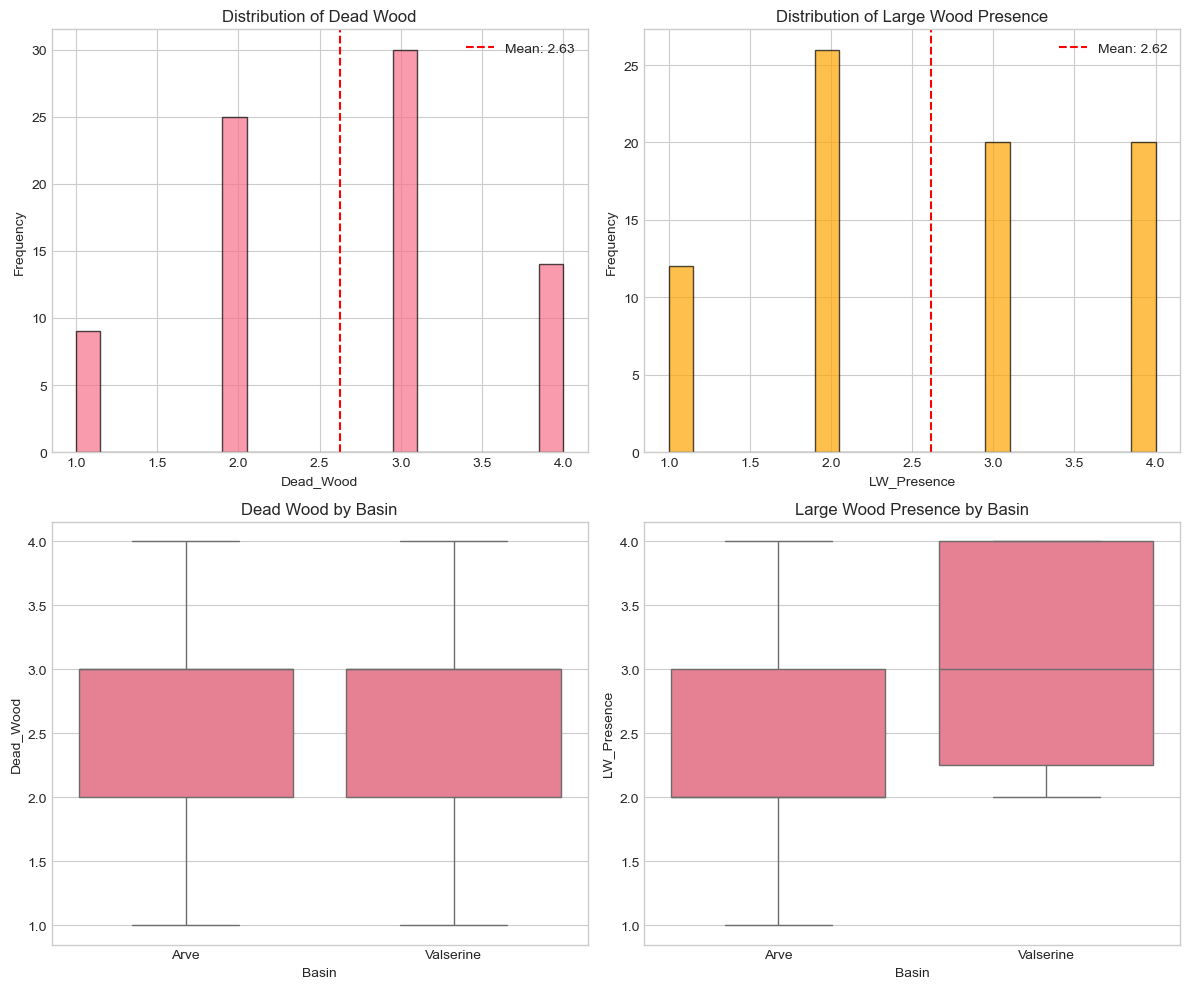

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Dead_Wood distribution
axes[0, 0].hist(df['Dead_Wood'].dropna(), bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Dead_Wood')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Dead Wood')
axes[0, 0].axvline(df['Dead_Wood'].mean(), color='red', linestyle='--', label=f'Mean: {df["Dead_Wood"].mean():.2f}')
axes[0, 0].legend()

# LW_Presence distribution
axes[0, 1].hist(df['LW_Presence'].dropna(), bins=20, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('LW_Presence')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Large Wood Presence')
axes[0, 1].axvline(df['LW_Presence'].mean(), color='red', linestyle='--', label=f'Mean: {df["LW_Presence"].mean():.2f}')
axes[0, 1].legend()

# Box plots by Basin
sns.boxplot(data=df, x='Basin', y='Dead_Wood', ax=axes[1, 0])
axes[1, 0].set_title('Dead Wood by Basin')

sns.boxplot(data=df, x='Basin', y='LW_Presence', ax=axes[1, 1])
axes[1, 1].set_title('Large Wood Presence by Basin')

plt.tight_layout()
plt.show()

## 4. Correlation Analysis

Analyzing relationships between all numeric variables and our target variables.

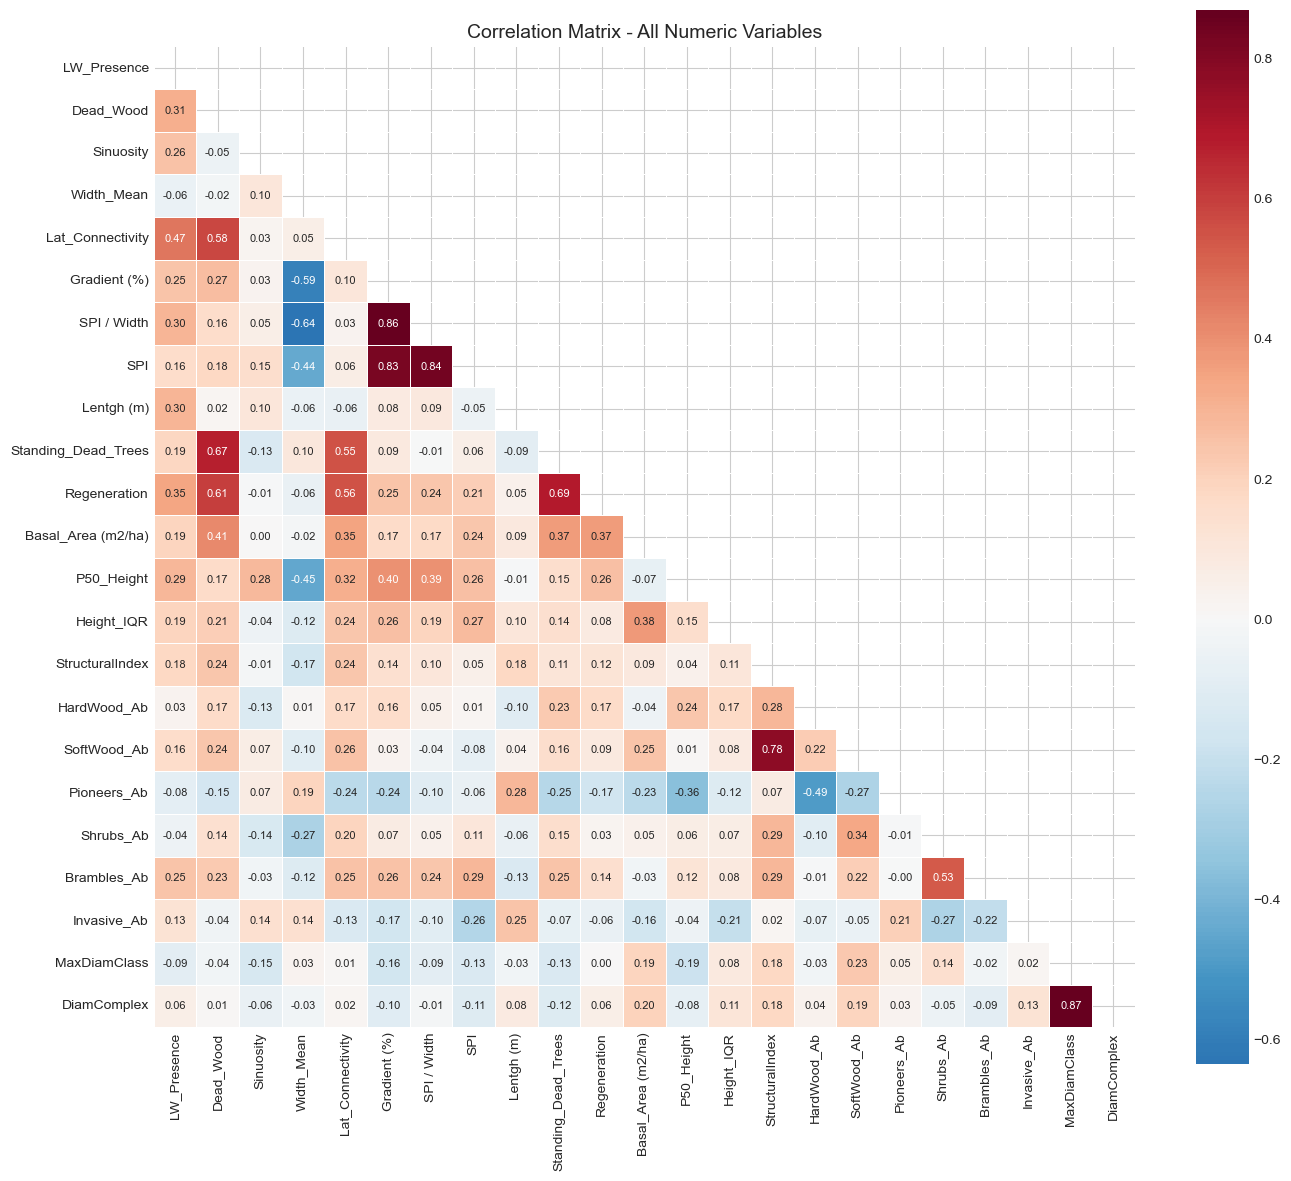

In [75]:
# Compute correlation matrix for all numeric columns
numeric_df = df[DATA_COLS].select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Define desired column order (targets first, then others as specified in the reference image)
# Include only columns that actually exist in the dataframe
desired_order = [
    'LW_Presence', 'Dead_Wood',  # Target variables first
    'Sinuosity', 'Width_Mean', 'Lat_Connectivity', 'Gradient (%)', 'SPI / Width', 'SPI', 'Lentgh (m)',
    'Standing_Dead_Trees', 'Regeneration', 'Basal_Area (m2/ha)', 'P50_Height',  'Height_IQR', 
    'StructuralIndex', 'HardWood_Ab', 'SoftWood_Ab', 'Pioneers_Ab', 'Shrubs_Ab', 
    'Brambles_Ab', 'Invasive_Ab', 'MaxDiamClass', 'DiamComplex', 
    'SizeSkewness', 
]

# Filter to only include columns that exist in the correlation matrix
available_cols = [col for col in desired_order if col in corr_matrix.columns]
# Add any remaining columns not in the desired order (in case there are extras)
remaining_cols = [col for col in corr_matrix.columns if col not in available_cols]
col_order = available_cols + remaining_cols

# Reorder the correlation matrix
corr_matrix_ordered = corr_matrix.loc[col_order, col_order]

# Full correlation heatmap
fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix_ordered, dtype=bool))  # Upper triangle mask
sns.heatmap(corr_matrix_ordered, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 8})
ax.set_title('Correlation Matrix - All Numeric Variables', fontsize=14)
plt.tight_layout()
plt.show()

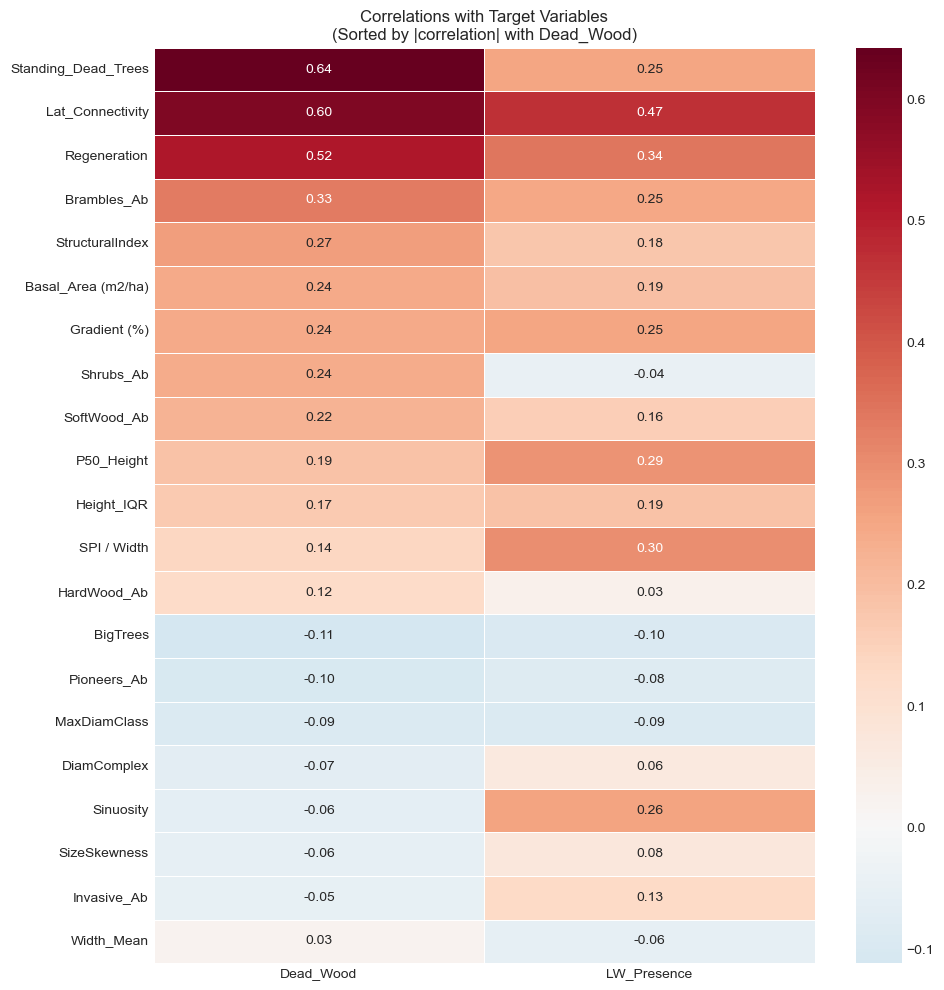

Top 5 correlates with Dead_Wood:
  Standing_Dead_Trees: 0.642
  Lat_Connectivity: 0.598
  Regeneration: 0.517
  Brambles_Ab: 0.334
  StructuralIndex: 0.271

Top 5 correlates with LW_Presence:
  Lat_Connectivity: 0.467
  Regeneration: 0.343
  SPI / Width: 0.296
  P50_Height: 0.290
  Sinuosity: 0.258


In [55]:
# Focus on correlations with target variables
target_corr = corr_matrix[TARGET_COLS].drop(TARGET_COLS)
target_corr = target_corr.reindex(target_corr['Dead_Wood'].abs().sort_values(ascending=False).index)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(target_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            linewidths=0.5, ax=ax, annot_kws={'size': 10})
ax.set_title('Correlations with Target Variables\n(Sorted by |correlation| with Dead_Wood)', fontsize=12)
plt.tight_layout()
plt.show()

# Print top correlates
print("Top 5 correlates with Dead_Wood:")
for var, val in target_corr['Dead_Wood'].head().items():
    print(f"  {var}: {val:.3f}")
    
print("\nTop 5 correlates with LW_Presence:")
for var, val in target_corr['LW_Presence'].abs().sort_values(ascending=False).head().items():
    corr_val = target_corr.loc[var, 'LW_Presence']
    print(f"  {var}: {corr_val:.3f}")

## 5. Scatter Plots - Key Relationships

This section visualizes how each of the **top correlated features** relates to our target variables (`Dead_Wood` and `LW_Presence`).

**How to read these plots:**
- **Top row:** Relationship of each feature with `Dead_Wood`
- **Bottom row:** Relationship of each feature with `LW_Presence`
- **Marker shape:** 
  - **Left half-circle** = Arve basin (purple)
  - **Right half-circle** = Valserine basin (yellow)
- **Point size:** For discrete variables, the size of each half-circle is proportional to the frequency of that (x, y) combination **within its own basin**. This allows visual comparison of relative frequencies between basins at the same data point.
- **r value:** Pearson correlation coefficient displayed in each subplot title

A higher absolute |r| indicates a stronger linear relationship. Positive r means the variables increase together; negative r means they move in opposite directions.

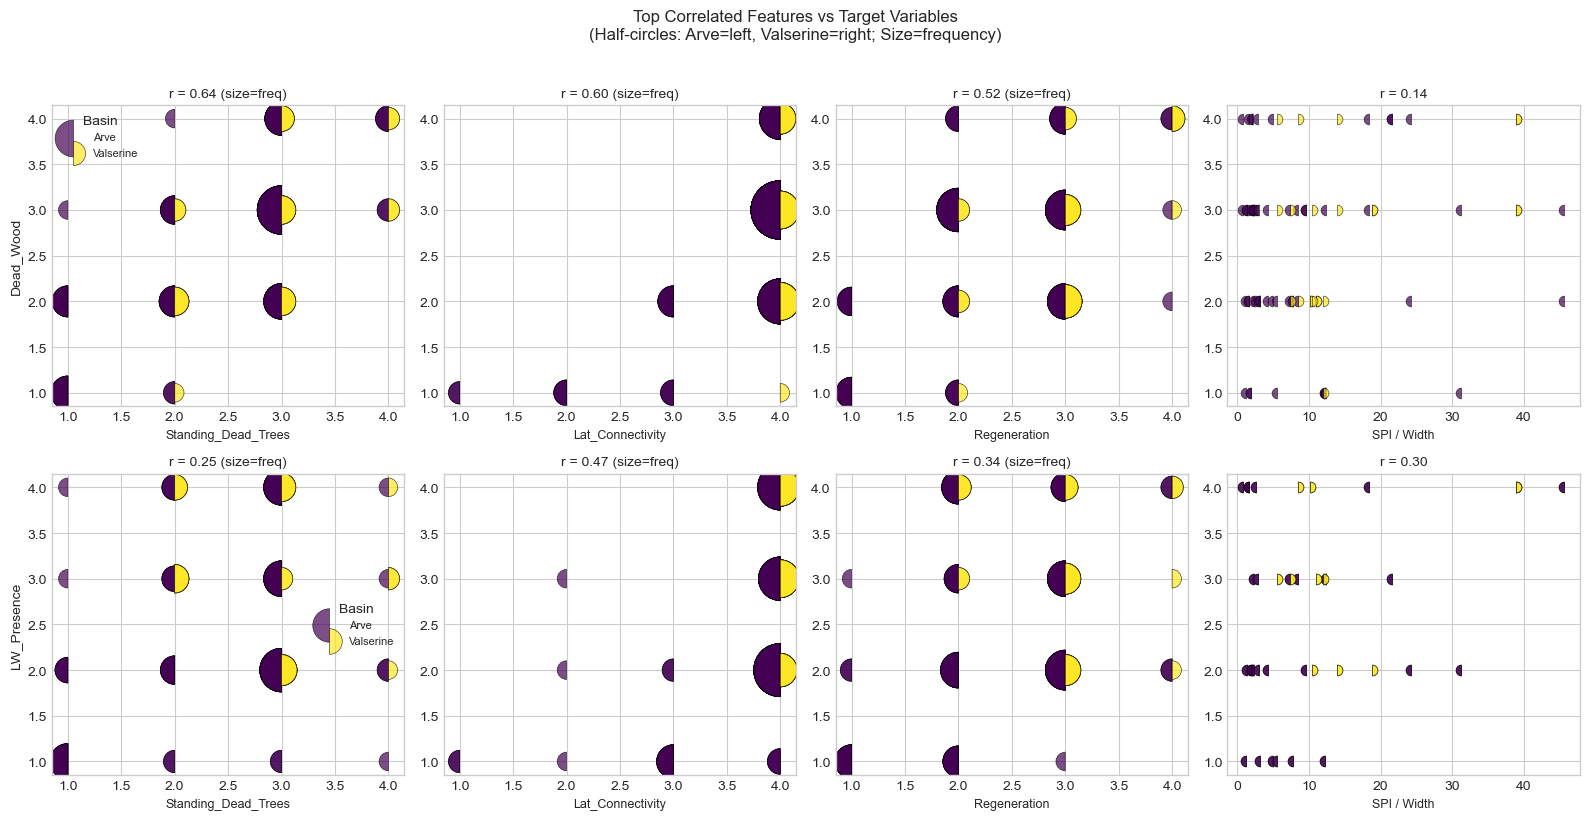

In [56]:
# Select top 6 correlated features (by absolute correlation with either target)
top_features_dw = target_corr['Dead_Wood'].abs().nlargest(3).index.tolist()
top_features_lw = target_corr['LW_Presence'].abs().nlargest(3).index.tolist()
top_features = list(dict.fromkeys(top_features_dw + top_features_lw))[:6]  # Unique, preserving order

# Define which features are discrete (for frequency-based sizing)
discrete_threshold = 10

def get_frequency_sizes_by_basin(x_data, y_data, basin_data, base_size=100, scale_factor=80):
    """Calculate point sizes based on frequency of (x, y) combinations per basin."""
    coords = pd.DataFrame({'x': x_data.values, 'y': y_data.values, 'basin': basin_data.values})
    # Calculate frequency per basin
    freq = coords.groupby(['x', 'y', 'basin']).size().reset_index(name='count')
    # Merge back
    coords_merged = coords.merge(freq, on=['x', 'y', 'basin'], how='left')
    sizes = base_size + coords_merged['count'] * scale_factor
    return sizes.values

# Create proper half-circle markers using Path with arc segments
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.patches as mpatches

def make_half_circle_left():
    """Left half circle marker (semicircle on the left side)."""
    # Use bezier curves to approximate a semicircle
    # Control point factor for circular arc approximation
    c = 0.55228  # Magic number for bezier circle approximation
    verts = [
        (0.0, 1.0),      # Top
        (-c, 1.0),       # Control point
        (-1.0, c),       # Control point
        (-1.0, 0.0),     # Left
        (-1.0, -c),      # Control point
        (-c, -1.0),      # Control point
        (0.0, -1.0),     # Bottom
        (0.0, 1.0),      # Close back to top
    ]
    codes = [
        Path.MOVETO,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CLOSEPOLY,
    ]
    return Path(verts, codes)

def make_half_circle_right():
    """Right half circle marker (semicircle on the right side)."""
    c = 0.55228
    verts = [
        (0.0, 1.0),      # Top
        (c, 1.0),        # Control point
        (1.0, c),        # Control point
        (1.0, 0.0),      # Right
        (1.0, -c),       # Control point
        (c, -1.0),       # Control point
        (0.0, -1.0),     # Bottom
        (0.0, 1.0),      # Close back to top
    ]
    codes = [
        Path.MOVETO,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CURVE4,
        Path.CLOSEPOLY,
    ]
    return Path(verts, codes)

left_half = make_half_circle_left()
right_half = make_half_circle_right()

# Color mapping for basins
basin_colors = {basin: plt.cm.viridis(i / (len(df['Basin'].unique()) - 1)) 
                for i, basin in enumerate(df['Basin'].unique())}

# Marker mapping: Arve = left half, Valserine = right half
basin_markers = {'Arve': left_half, 'Valserine': right_half}

fig, axes = plt.subplots(2, len(top_features), figsize=(4*len(top_features), 8))

for i, feat in enumerate(top_features):
    is_discrete = df[feat].nunique() < discrete_threshold
    
    if is_discrete:
        # Calculate sizes per basin for this feature
        sizes_dict = {}
        for basin in df['Basin'].unique():
            mask = df['Basin'] == basin
            x_vals = df.loc[mask, feat]
            y_vals_dw = df.loc[mask, 'Dead_Wood']
            y_vals_lw = df.loc[mask, 'LW_Presence']
            sizes_dict[(basin, 'Dead_Wood')] = get_frequency_sizes_by_basin(
                df.loc[mask, feat], df.loc[mask, 'Dead_Wood'], df.loc[mask, 'Basin'])
            sizes_dict[(basin, 'LW_Presence')] = get_frequency_sizes_by_basin(
                df.loc[mask, feat], df.loc[mask, 'LW_Presence'], df.loc[mask, 'Basin'])
    
    # Dead_Wood scatter
    for j, basin in enumerate(df['Basin'].unique()):
        mask = df['Basin'] == basin
        x_vals = df.loc[mask, feat]
        y_vals = df.loc[mask, 'Dead_Wood']
        
        if is_discrete:
            sizes = sizes_dict[(basin, 'Dead_Wood')]
        else:
            sizes = 60
            
        axes[0, i].scatter(x_vals, y_vals, 
                          alpha=0.7, label=basin if i == 0 else '', 
                          color=basin_colors[basin], s=sizes,
                          marker=basin_markers[basin], edgecolors='black', linewidth=0.5)
    axes[0, i].set_xlabel(feat, fontsize=9)
    axes[0, i].set_ylabel('Dead_Wood' if i == 0 else '')
    r = df[[feat, 'Dead_Wood']].corr().iloc[0, 1]
    axes[0, i].set_title(f'r = {r:.2f}' + (' (size=freq)' if is_discrete else ''), fontsize=10)
    
    # LW_Presence scatter
    for j, basin in enumerate(df['Basin'].unique()):
        mask = df['Basin'] == basin
        x_vals = df.loc[mask, feat]
        y_vals = df.loc[mask, 'LW_Presence']
        
        if is_discrete:
            sizes = sizes_dict[(basin, 'LW_Presence')]
        else:
            sizes = 60
            
        axes[1, i].scatter(x_vals, y_vals, 
                          alpha=0.7, label=basin if i == 0 else '',
                          color=basin_colors[basin], s=sizes,
                          marker=basin_markers[basin], edgecolors='black', linewidth=0.5)
    axes[1, i].set_xlabel(feat, fontsize=9)
    axes[1, i].set_ylabel('LW_Presence' if i == 0 else '')
    r = df[[feat, 'LW_Presence']].corr().iloc[0, 1]
    axes[1, i].set_title(f'r = {r:.2f}' + (' (size=freq)' if is_discrete else ''), fontsize=10)

# Add legend to the first column with custom markers
axes[0, 0].legend(title='Basin', loc='best', fontsize=8)
axes[1, 0].legend(title='Basin', loc='best', fontsize=8)

plt.suptitle('Top Correlated Features vs Target Variables\n(Half-circles: Arve=left, Valserine=right; Size=frequency)', 
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

Using Random Forest to identify which features are most predictive of our target variables.

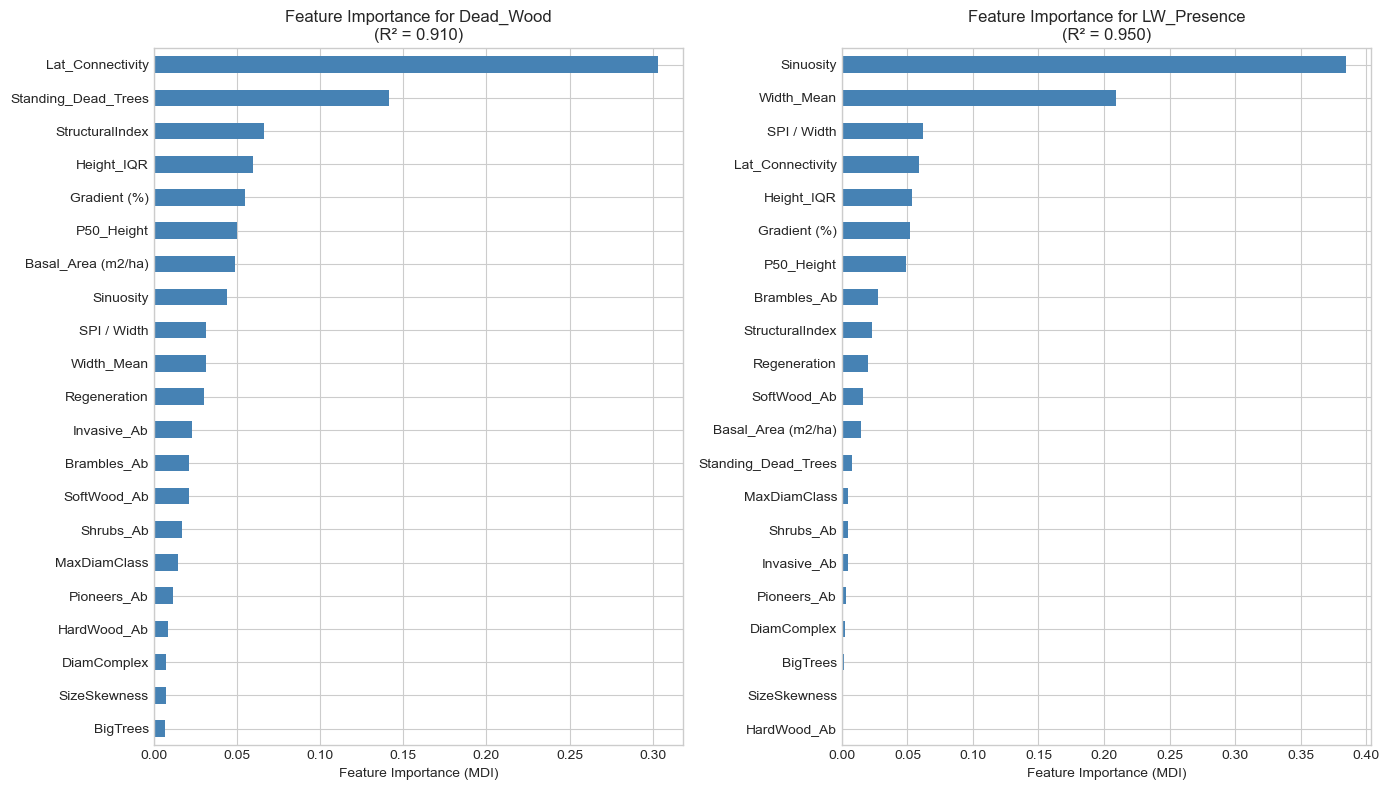

In [57]:
# Prepare feature matrix (numeric features only, drop rows with NaN)
X = df[FEATURE_COLS].select_dtypes(include=[np.number])
feature_names = X.columns.tolist()

# Results storage
importance_results = {}

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

for idx, target in enumerate(TARGET_COLS):
    # Prepare data (drop rows with NaN in either features or target)
    valid_mask = X.notna().all(axis=1) & df[target].notna()
    X_valid = X[valid_mask]
    y_valid = df.loc[valid_mask, target]
    
    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_valid, y_valid)
    
    # Get feature importances
    importances = pd.Series(rf.feature_importances_, index=feature_names)
    importances = importances.sort_values(ascending=True)
    importance_results[target] = importances
    
    # Plot
    importances.plot(kind='barh', ax=axes[idx], color='steelblue')
    axes[idx].set_xlabel('Feature Importance (MDI)')
    axes[idx].set_title(f'Feature Importance for {target}\n(R² = {rf.score(X_valid, y_valid):.3f})')

plt.tight_layout()
plt.show()

In [58]:
# Compare top important features for both targets
print("Top 5 Important Features Comparison:")
print("="*60)
print(f"{'Rank':<6}{'Dead_Wood':<25}{'LW_Presence':<25}")
print("-"*60)

dw_top = importance_results['Dead_Wood'].nlargest(5)
lw_top = importance_results['LW_Presence'].nlargest(5)

for i in range(5):
    dw_feat = f"{dw_top.index[i]} ({dw_top.iloc[i]:.3f})"
    lw_feat = f"{lw_top.index[i]} ({lw_top.iloc[i]:.3f})"
    print(f"{i+1:<6}{dw_feat:<25}{lw_feat:<25}")

Top 5 Important Features Comparison:
Rank  Dead_Wood                LW_Presence              
------------------------------------------------------------
1     Lat_Connectivity (0.303) Sinuosity (0.385)        
2     Standing_Dead_Trees (0.141)Width_Mean (0.209)       
3     StructuralIndex (0.067)  SPI / Width (0.062)      
4     Height_IQR (0.060)       Lat_Connectivity (0.059) 
5     Gradient (%) (0.055)     Height_IQR (0.054)       


## 7. Relationship Between Target Variables

This section explores **how our two main variables of interest relate to each other**. Understanding this relationship is important because:
- If they are highly correlated, they may be driven by similar underlying ecological processes
- If they differ by basin, it suggests location-specific factors influence their relationship

**How to read these plots:**
- **Left plot:** Overall scatter of Dead_Wood vs LW_Presence, colored by Basin
- **Right plot:** Same relationship but with **linear regression trend lines** for each Basin
- **r value:** Overall Pearson correlation between the two target variables

The dashed trend lines show whether the relationship direction/strength differs between the Arve and Valserine basins.

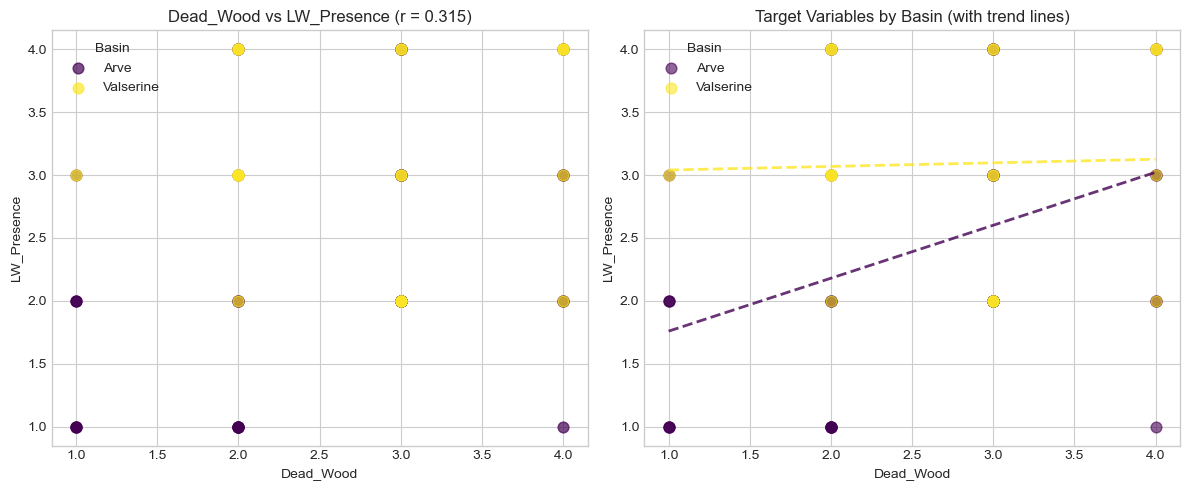


Correlation between Dead_Wood and LW_Presence by Basin:
  Arve: r = 0.377
  Valserine: r = 0.031


In [59]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Color palette for basins
basin_colors = {basin: plt.cm.viridis(i / (len(df['Basin'].unique()) - 1)) 
                for i, basin in enumerate(df['Basin'].unique())}

# Left plot: Scatter plot of target variables with proper legend
for basin in df['Basin'].unique():
    subset = df[df['Basin'] == basin]
    axes[0].scatter(subset['Dead_Wood'], subset['LW_Presence'], 
                   c=[basin_colors[basin]], alpha=0.7, s=60, label=basin)

axes[0].set_xlabel('Dead_Wood')
axes[0].set_ylabel('LW_Presence')
r = df[['Dead_Wood', 'LW_Presence']].corr().iloc[0, 1]
axes[0].set_title(f'Dead_Wood vs LW_Presence (r = {r:.3f})')
axes[0].legend(title='Basin', loc='best')

# Right plot: Distribution by Basin with regression lines
for basin in df['Basin'].unique():
    subset = df[df['Basin'] == basin]
    axes[1].scatter(subset['Dead_Wood'], subset['LW_Presence'], 
                   alpha=0.6, s=60, label=basin, c=[basin_colors[basin]])
    # Add regression line per basin
    z = np.polyfit(subset['Dead_Wood'].dropna(), 
                   subset.loc[subset['Dead_Wood'].notna(), 'LW_Presence'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(subset['Dead_Wood'].min(), subset['Dead_Wood'].max(), 100)
    axes[1].plot(x_line, p(x_line), '--', alpha=0.8, color=basin_colors[basin], linewidth=2)

axes[1].set_xlabel('Dead_Wood')
axes[1].set_ylabel('LW_Presence')
axes[1].set_title('Target Variables by Basin (with trend lines)')
axes[1].legend(title='Basin', loc='best')

plt.tight_layout()
plt.show()

# Print correlation by basin
print("\nCorrelation between Dead_Wood and LW_Presence by Basin:")
for basin in df['Basin'].unique():
    subset = df[df['Basin'] == basin]
    r_basin = subset[['Dead_Wood', 'LW_Presence']].corr().iloc[0, 1]
    print(f"  {basin}: r = {r_basin:.3f}")

## 8. Summary Statistics by Location

Examining how target variables vary across different Sub-Basins.

Target Variables by Location:


Dead_Wood                         LW_Presence            \
                         mean       std min max count        mean       std   
Basin     Sub_Basin                                                           
Arve      Arve       2.441176  1.020730   1   4    34    2.294118  1.142284   
          Giffre     2.812500  0.834166   1   4    16    2.375000  0.885061   
          Menoge     2.833333  0.752773   2   4     6    3.333333  0.516398   
Valserine Semine     2.375000  0.916125   1   4     8    3.000000  0.755929   
          Valserine  3.000000  0.784465   2   4    14    3.142857  0.864438   

                                   
                    min max count  
Basin     Sub_Basin                
Arve      Arve        1   4    34  
          Giffre      1   4    16  
          Menoge      3   4     6  
Valserine Semine      2   4     8  
          Valserine   2   4    14

C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_22968\3129478938.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\jdelhoyo\AppData\Local\Temp\ipykernel_22968\3129478938.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


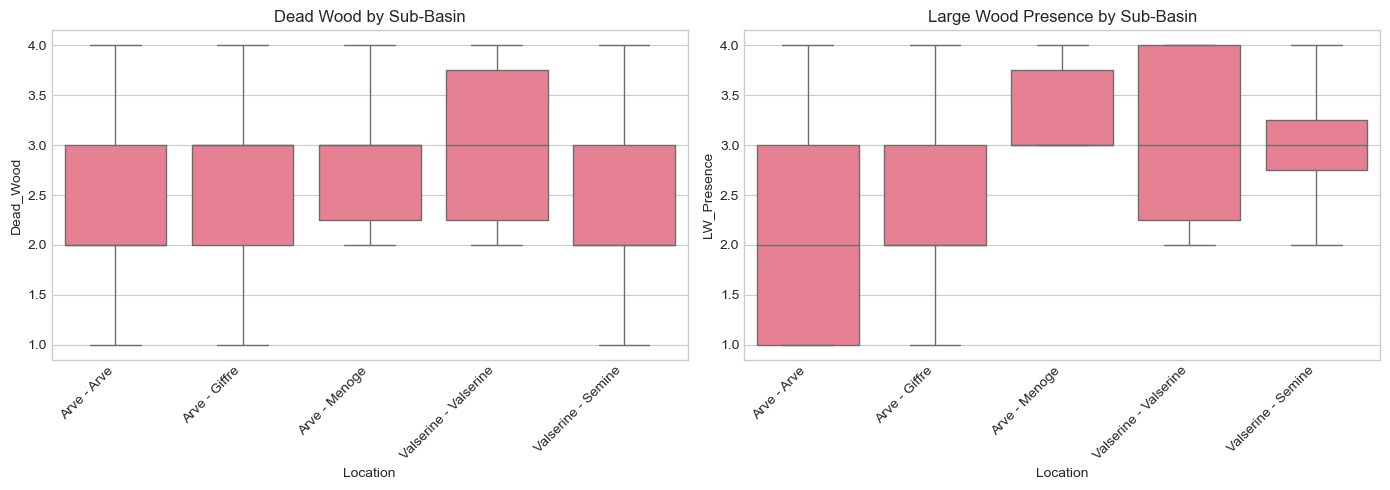

In [60]:
# Summary by Sub_Basin
location_summary = df.groupby(['Basin', 'Sub_Basin'])[TARGET_COLS + FEATURE_COLS[:5]].agg(['mean', 'std', 'count'])
location_summary = location_summary.round(2)

# Display target variable summary
target_summary = df.groupby(['Basin', 'Sub_Basin'])[TARGET_COLS].agg(['mean', 'std', 'min', 'max', 'count'])
print("Target Variables by Location:")
print("="*80)
display(target_summary)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df_plot = df.copy()
df_plot['Location'] = df_plot['Basin'] + ' - ' + df_plot['Sub_Basin']

sns.boxplot(data=df_plot, x='Location', y='Dead_Wood', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title('Dead Wood by Sub-Basin')

sns.boxplot(data=df_plot, x='Location', y='LW_Presence', ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title('Large Wood Presence by Sub-Basin')

plt.tight_layout()
plt.show()